In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from tqdm import trange

import sys
sys.path.append('../')
from CAS import *

## ABCD-o graphs

* ground-truth saved in 'gt' vertex attribute


In [2]:
# ABCD+o only in Julia for now - update path below as needed

## local:
# abcd_path = '/Users/francois/ABCD/ABCDo/ABCDGraphGenerator.jl/utils/'
# julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia '

## Dev02:
abcd_path = '/home/rdewolfe/research/ABCDGraphGenerator.jl/utils/'
julia = '/home/rdewolfe/.juliaup/bin/julia '

def _run_julia_abcd(n=1000, xi=0.3, delta=5, zeta=0.5, gamma=2.5, s=25, tau=0.825, beta=1.5, seed=123, nout=0):
    D = int(n**zeta)
    S = int(n**tau) 
    rdm = str(np.random.choice(100000))
    fn_deg = 'deg_'+rdm+'.dat'
    fn_cs = 'cs_'+rdm+'.dat'
    fn_comm = 'comm_'+rdm+'.dat'
    fn_net = 'net_'+rdm+'.dat'
    ## generate graph
    cmd = julia+abcd_path+'deg_sampler.jl '+fn_deg+' '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000 '+str(seed)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'com_sampler.jl '+fn_cs+' '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000 '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'graph_sampler.jl '+fn_net+' '+fn_comm+' '+fn_deg+' '+fn_cs+' xi '+str(xi)+' false false '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    g = ig.Graph.Read_Ncol(fn_net,directed=False)
    c = np.loadtxt(fn_comm,dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(i['name'])-1]-1 for i in g.vs]
    g.vs['gt'] = gt
    cmd = 'rm *_'+rdm+'.dat'
    os.system(cmd+' >/dev/null 2>&1')
    return g

In [3]:
## first with "mid-size" graphs
XIs = [.35,.4,.45,.5,.55,.575,.6,.625,.65]
REP = 1
num_nodes = 1000
num_out = 25
delta = 10
min_comm = 50
alpha = 1

In [4]:
xi=0.5
g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                        zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

## The Experiments

Use the CAS to predict wether an edge is intra-community or inter-community.
Similar to ECG, average this weight over several first step Louvain runs.
Basically weighting ECG belief with CAS instead of just 1-0 are in cluster.

## Updating ECG code

In [19]:
def community_ecg(self, weights=None, ens_size = 16, min_weight = 0.05, 
                  final='louvain', resolution=1.0, refuse_score=False):
    """
    Stable ensemble-based graph clustering;
    the ensemble consists of single-level randomized Louvain; 
    each member of the ensemble gets a "vote" to determine if the edges 
    are intra-community or not;
    the votes are aggregated into ECG edge-weights in range [0,1]; 
    a final (full depth) Louvain is run using those edge weights;
    
    Parameters
    ----------
    self: graph of type 'igraph.Graph'
      Graph to define the partition on.
    weights: list of double, optional 
      the edge weights
    ens_size: int, optional
      the size of the ensemble of single-level Louvain
    min_weight: double in range [0,1], optional
      the ECG edge weight for edges with zero votes from the ensemble
    final: 'louvain' (default) or 'leiden'
      the algorithm to run on the final re-weighted graph
    resolution: positive float, optional
      resolution parameter; larger values favors smaller communities
      
    Returns
    -------
    partition
      The final partition, of type 'igraph.clustering.VertexClustering'
    partition.W
      The ECG edge weights
    partition.CSI
      The community strength index
    partition.original_modularity
      The modularity with respect to the original edge weights

    Notes
    -----
    The ECG edge weight function is defined as:
      
      min_weight + ( 1 - min_weight ) x (#votes_in_ensemble) / ens_size
      
    Edges outside the 2-core are assigned 'min_weight'.
    
    Examples
    --------
    >>> g = igraph.Graph.Famous('Zachary')
    >>> part = g.community_ecg(ens_size=25, min_weight = .1)
    >>> print(part.CSI)
    
    Reference
    ---------
    Valérie Poulin and François Théberge, "Ensemble clustering for graphs: comparisons and applications", Appl Netw Sci 4, 51 (2019). 
    https://doi.org/10.1007/s41109-019-0162-z
    """
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l1 = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l1[p[x.tuple[0]]]==l1[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    # core = self.shell_index()
    # ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    # w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    if final=='leiden':
        part = self.community_leiden(weights=W, objective_function='modularity', resolution=resolution)
    else:
        part = self.community_multilevel(weights=W, resolution=resolution)
    part.W = W
    part.CSI = 1-2*np.sum([min(1-i,i) for i in W])/len(W)
    part._modularity_params['weights'] = weights
    part.recalculate_modularity()
    
    ## experimental - "refuse to cluster" scores
    # if refuse_score:
    #    self.vs['_deg'] = self.degree()
    #    self.es['_W'] = part.W
    #    self.vs['_ecg'] = part.membership
    #    for v in self.vs:
    #        scr = 0
    #        my_comm = v['_ecg']
    #        good = 0
    #        bad = 0
    #        for e in v.incident():
    #            scr += e['_W']
    #            if self.vs[e.source]['_ecg'] == self.vs[e.target]['_ecg']:
    #                good += e['_W']
    #            else:
    #                bad += e['_W']
    #        v['_overall'] = ((v['_deg']-scr)/v['_deg'])
    #        v['_community'] = (bad/(bad+good))        
    #    part.refuse_overall = self.vs['_overall']
    #    part.refuse_community = self.vs['_community']
    #    del(self.vs['_deg'])
    #    del(self.es['_W'])
    #    del(self.vs['_ecg'])
    #   del(self.vs['_overall'])
    #   del(self.vs['_community'])            
    ## end experimental scores
    
    return part

ig.Graph.community_ecg = community_ecg

In [6]:
clusters = g.community_multilevel(return_levels=True)[0].membership
cluster_matrix = partition2sparse(clusters)
graph_matrix = g.get_adjacency_sparse()
ief, beta, c, p, degs = CAS(graph_matrix, cluster_matrix)

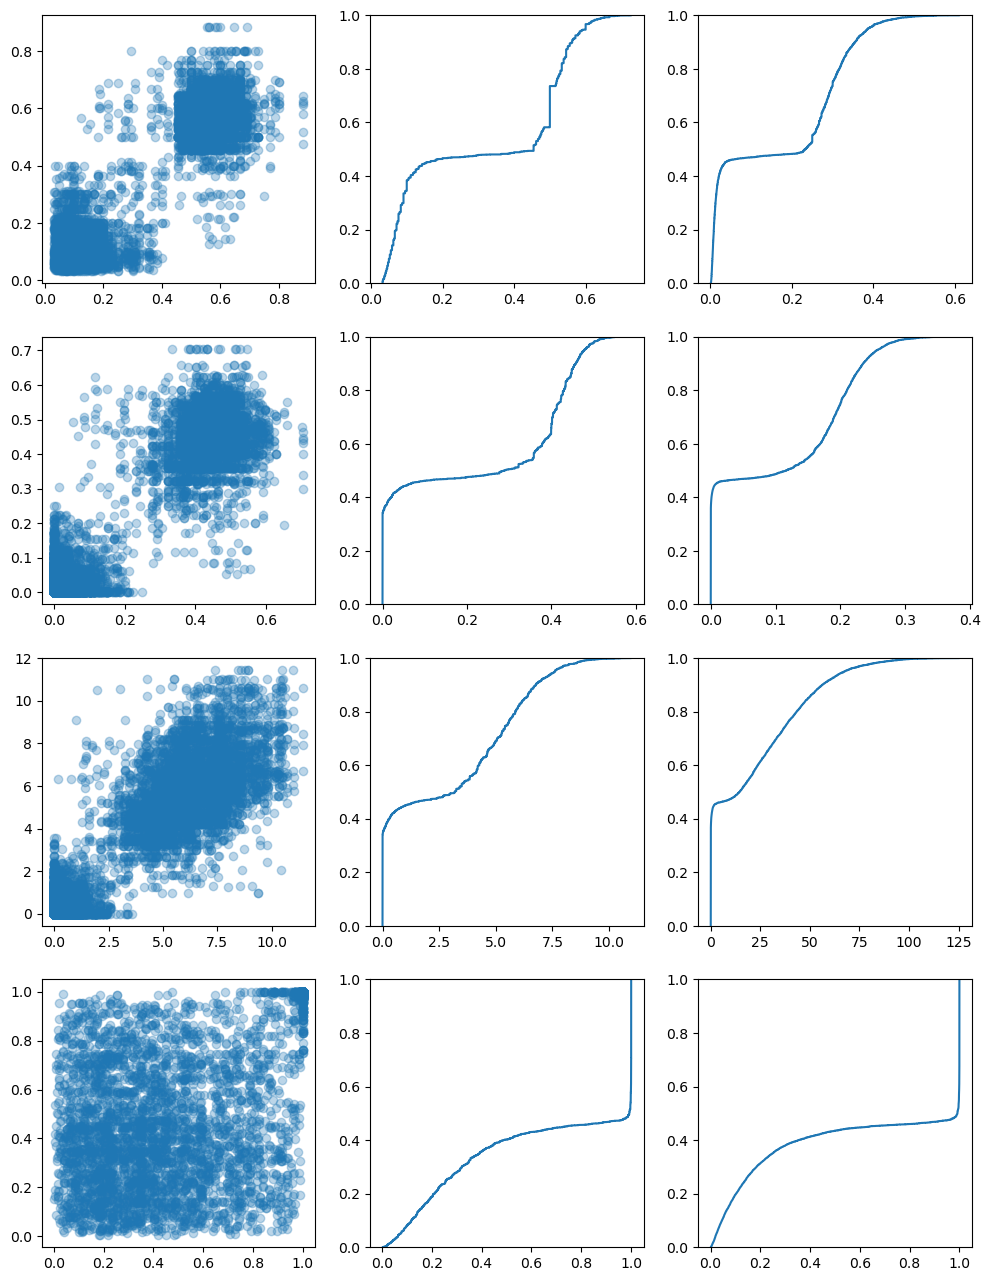

In [7]:
#Plotting potential edge weights
# First column is CAS x: e1 to the community of e2, y: e2 to the community of e1
# Second column is CDF-ish thing of taking the min value
# Thrid column is CDF-ish thing of x*y

fig, axs = plt.subplots(4, 3, figsize=(12,16))
for i, m in enumerate([ief, beta, c, p]):
    e1_to_e2 = np.array([m[e.source, clusters[e.target]] for e in g.es])
    e2_to_e1 = np.array([m[e.target, clusters[e.source]] for e in g.es])
    axs[i, 0].scatter(e1_to_e2, e2_to_e1, alpha=0.3)
    axs[i, 1].ecdf(np.minimum(e1_to_e2, e2_to_e1))
    axs[i, 2].ecdf(e1_to_e2*e2_to_e1)

In [8]:
ens_size = 2
G = g

print("What")

What


In [9]:
ief_sum = np.zeros(g.ecount())
beta_sum = np.zeros(g.ecount())
c_sum = np.zeros(g.ecount())
p_sum = np.zeros(g.ecount())

print("What2")

What2


In [10]:
perm = np.random.permutation(G.vcount()).tolist()
x = G.permute_vertices(perm)
l1 = x.community_multilevel(weights=None, return_levels=True)[0].membership

In [11]:
for i in trange(ens_size):
    perm = np.random.permutation(G.vcount()).tolist()
    print("Check1")
    g = G.permute_vertices(perm)
    l1 = g.community_multilevel(weights=None, return_levels=True)[0].membership

100%|██████████| 2/2 [00:00<00:00, 139.36it/s]

Check1
Check1


In [20]:
def normalize(x, eps=10**-5):
    return x / (np.max(x) - np.min(x) + eps)

def ecg_CAS(G, ens_size, min_weight=0.05):
    ens_size = 16

    ief_min_sum = np.zeros(G.ecount())
    beta_min_sum = np.zeros(G.ecount())
    c_min_sum = np.zeros(G.ecount())
    p_min_sum = np.zeros(G.ecount())

    ief_prod_sum = np.zeros(G.ecount())
    beta_prod_sum = np.zeros(G.ecount())
    c_prod_sum = np.zeros(G.ecount())
    p_prod_sum = np.zeros(G.ecount())    

    ## Ensemble of level-1 Louvain
    for i in range(ens_size):
        perm = np.random.permutation(G.vcount()).tolist()
        g = G.permute_vertices(perm)
        clusters = g.community_multilevel(weights=None, return_levels=True)[0].membership
    
        cluster_matrix = partition2sparse(clusters)
        graph_matrix = g.get_adjacency_sparse()
        ief, beta, c, p, degs = CAS(graph_matrix, cluster_matrix)
        options = [
            [ief_min_sum, ief_prod_sum, ief],
            [beta_min_sum, beta_prod_sum, beta],
            [c_min_sum, c_prod_sum, c],
            [p_min_sum, p_prod_sum, p],
            ]
        for total_min_sum, total_prod_sum, m in options:
            e1_to_e2 = np.array([m[perm[e.source], clusters[perm[e.target]]] for e in g.es])
            e2_to_e1 = np.array([m[perm[e.target], clusters[perm[e.source]]] for e in g.es])
            total_min_sum += normalize(np.minimum(e1_to_e2, e2_to_e1))
            total_prod_sum += normalize(e1_to_e2 * e2_to_e1)
        
    result_dict = dict()
    result_dict["ief_min"] = G.community_leiden(weights=np.minimum(ief_min_sum/ens_size, np.full(G.ecount(), min_weight)), objective_function='modularity').membership
    result_dict["beta_min"] = G.community_leiden(weights=np.minimum(beta_min_sum/ens_size, np.full(G.ecount(), min_weight)), objective_function='modularity').membership
    result_dict["c_min"] = G.community_leiden(weights=np.minimum(c_min_sum/ens_size, np.full(G.ecount(), min_weight)), objective_function='modularity').membership
    result_dict["p_min"] = G.community_leiden(weights=np.minimum(p_min_sum, np.full(G.ecount(), min_weight)), objective_function='modularity').membership

    result_dict["ief_prod"] = G.community_leiden(weights=np.minimum(ief_prod_sum/ens_size, np.full(G.ecount(), min_weight)), objective_function='modularity').membership
    result_dict["beta_prod"] = G.community_leiden(weights=np.minimum(beta_prod_sum/ens_size, np.full(G.ecount(), min_weight)), objective_function='modularity').membership
    result_dict["c_prod"] = G.community_leiden(weights=np.minimum(c_prod_sum/ens_size, np.full(G.ecount(), min_weight)), objective_function='modularity').membership
    result_dict["p_prod"] = G.community_leiden(weights=np.minimum(p_prod_sum/ens_size, np.full(G.ecount(), min_weight)), objective_function='modularity').membership
    return result_dict
    
    


In [13]:
results = ecg_CAS(g, 16)

In [14]:
for m, v in results.items():
    print(m, AMI(v, g.vs["gt"]))

ief_min 0.9436934890039201
beta_min 0.7094988840683603
c_min 0.813844704232027
p_min 0.9510070298700816
ief_prod 0.8674863734306038
beta_prod 0.6937558342442846
c_prod 0.6156539344791464
p_prod 0.9213878266293889


## Some experiments on small ABCDo graphs

In [15]:
## first with "mid-size" graphs
XIs = [.35,.4,.45,.5,.55,.575,.6,.625,.65, .675, .7]
REP = 1
num_nodes = 1000
num_out = 0
delta = 10
min_comm = 100
alpha = 1

In [21]:
ens_size = 16
n_runs = 25

ief_min = np.empty((len(XIs), n_runs))
beta_min = np.empty((len(XIs), n_runs))
c_min = np.empty((len(XIs), n_runs))
p_min = np.empty((len(XIs), n_runs))
ief_prod = np.empty((len(XIs), n_runs))
beta_prod = np.empty((len(XIs), n_runs))
c_prod = np.empty((len(XIs), n_runs))
p_prod = np.empty((len(XIs), n_runs))
ecg = np.empty((len(XIs), n_runs))
leiden = np.empty((len(XIs), n_runs))


for i, xi in enumerate(XIs):
    for run in trange(n_runs):
        g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)
        results = ecg_CAS(g, 16)
        ief_min[i, run] = AMI(results["ief_min"], g.vs["gt"])
        beta_min[i, run] = AMI(results["beta_min"], g.vs["gt"])
        c_min[i, run] = AMI(results["c_min"], g.vs["gt"])
        p_min[i, run] = AMI(results["p_min"], g.vs["gt"])
        ief_prod[i, run] = AMI(results["ief_prod"], g.vs["gt"])
        beta_prod[i, run] = AMI(results["beta_prod"], g.vs["gt"])
        c_prod[i, run] = AMI(results["c_prod"], g.vs["gt"])
        p_prod[i, run] = AMI(results["p_prod"], g.vs["gt"])
        ecg[i, run] = AMI(community_ecg(g, ens_size=ens_size, final="leiden").membership, g.vs["gt"])
        leiden[i, run] = AMI(g.community_leiden(objective_function='modularity').membership, g.vs["gt"])

100%|██████████| 25/25 [06:15<00:00, 15.04s/it]


Text(0.5, 1.0, 'ECG weighted with CAS clustering.')

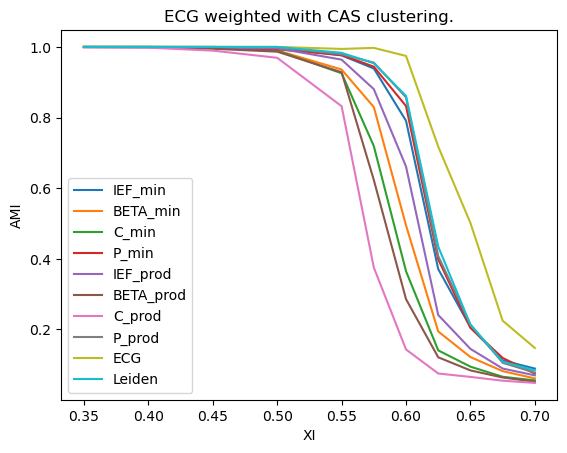

In [22]:
plt.plot(XIs, np.mean(ief_min, axis=1), label="IEF_min")
plt.plot(XIs, np.mean(beta_min, axis=1), label="BETA_min")
plt.plot(XIs, np.mean(c_min, axis=1), label="C_min")
plt.plot(XIs, np.mean(p_min, axis=1), label="P_min")

plt.plot(XIs, np.mean(ief_prod, axis=1), label="IEF_prod")
plt.plot(XIs, np.mean(beta_prod, axis=1), label="BETA_prod")
plt.plot(XIs, np.mean(c_prod, axis=1), label="C_prod")
plt.plot(XIs, np.mean(p_prod, axis=1), label="P_prod")

plt.plot(XIs, np.mean(ecg, axis=1), label="ECG")
plt.plot(XIs, np.mean(leiden, axis=1), label="Leiden")

plt.legend()
plt.xlabel("XI")
plt.ylabel("AMI")
plt.title("ECG weighted with CAS clustering.")